### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd

dist =torch.distributions

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
pt1 = torch.tensor([[1.0, 0.0],
                    [1.0, 0.0],
                    [1.0, 0.0],
                    [1.0, 0.0]
                    ])
pt2 = torch.tensor([[0.5, 0.5],
                    [0.5, 0.5],
                    [0.5, 0.5],
                    [0.5, 0.5]
                    ])
pt3 = torch.tensor([[0.0, 1.0],
                    [1.0, 0.0],
                    [0.0, 1.0],
                    [1.0, 0.0]
                    ])


In [3]:
def avg_prob(pt):
    return torch.mean(pt, dim=0)

avg_prob(pt1), avg_prob(pt2), avg_prob(pt3)

(tensor([1., 0.]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]))

In [4]:
def predictive_entropy(pt):
    avg = avg_prob(pt)
    return -torch.sum(avg * torch.log2(avg))


In [5]:
predictive_entropy(pt1), predictive_entropy(pt2), predictive_entropy(pt3)

(tensor(nan), tensor(1.), tensor(1.))

In [6]:
# Numerically stable version to compute entropy by avoiding log(0)
def predictive_entropy(pt):
    avg = avg_prob(pt)
    return -torch.sum(avg * torch.log2(avg + 1e-8))

predictive_entropy(pt1), predictive_entropy(pt2), predictive_entropy(pt3)

(tensor(-0.), tensor(1.), tensor(1.))

In [7]:
def expected_entropy(pt):
    return torch.mean(torch.sum(-pt * torch.log2(pt + 1e-8), dim=1))

expected_entropy(pt1), expected_entropy(pt2), expected_entropy(pt3)

(tensor(0.), tensor(1.), tensor(0.))

In [8]:
def mutual_information(pt):
    return predictive_entropy(pt) - expected_entropy(pt)

mutual_information(pt1), mutual_information(pt2), mutual_information(pt3)

(tensor(-0.), tensor(0.), tensor(1.))

### Example from Gal et al.

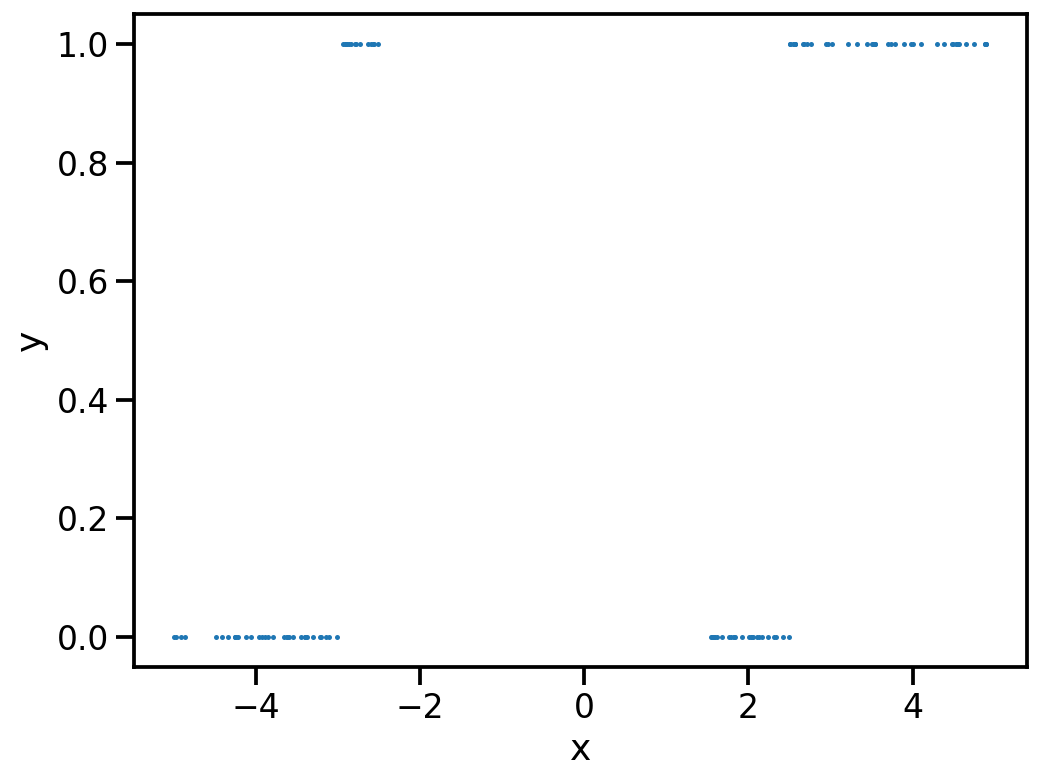

In [156]:
# Training data

# Between -5 and -3, y = 0, and we have n1 = 100
# Between -3 and -2, y = 1, and we have n2 = 50
# Between 1 and 2.5, y = 0, and we have n3 = 75
# Between 2.5 and 5, y = 1, and we have n4 = 125

fac = 30
# Generate data
n1 = 1000//fac
n2 = 500//fac
n3 = 750//fac
n4 = 1250//fac

x1 = dist.Uniform(-5, -3).sample((n1,))
x2 = dist.Uniform(-3, -2.5).sample((n2,))
x3 = dist.Uniform(1.5, 2.5).sample((n3,))
x4 = dist.Uniform(2.5, 5).sample((n4,))

x = torch.cat([x1, x2, x3, x4])
y = torch.cat([torch.zeros(n1), torch.ones(n2), torch.zeros(n3), torch.ones(n4)])

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=1)
plt.xlabel("x")
plt.ylabel("y")

# Move to GPU
x = x.cuda()
y = y.cuda()

In [157]:
# Simple MLP with 4 layers and dropout in between
import torch.functional as F

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.nn.GELU()(self.fc1(x))
        x = self.dropout(x)
        x = torch.nn.GELU()(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [185]:
# Training loop

def train(model, x, y, optimizer, loss_fn, num_epochs):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred.squeeze(), y)
        loss.backward()
        optimizer.step()
        if epoch % 300 == 0:
            print(f"Epoch {epoch}, loss {loss.item():.4f}")

# Train the model
model = MLP(1, 16, 1, 0.2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
train(model, x.unsqueeze(1), y, optimizer, loss_fn, 4000)

Epoch 0, loss 0.7011
Epoch 300, loss 0.0829
Epoch 600, loss 0.0474
Epoch 900, loss 0.0192


In [177]:
# At test time, we want to use MC dropout to get the predictive distribution

def predict(model, x, num_mc_samples):
    model.train()
    y_preds = []
    for _ in range(num_mc_samples):
        y_pred = torch.sigmoid(model(x.unsqueeze(1)))
        y_preds.append(y_pred.detach().cpu().numpy())
    return np.concatenate(y_preds, axis=1)

# Plot the predictive distribution
x_test = torch.linspace(-7, 7, 1000).cuda()
y_test = predict(model, x_test, 2000) # 500 MC samples


In [178]:
y_test_orig = torch.from_numpy(y_test)
y_test_orig.shape

torch.Size([1000, 2000])

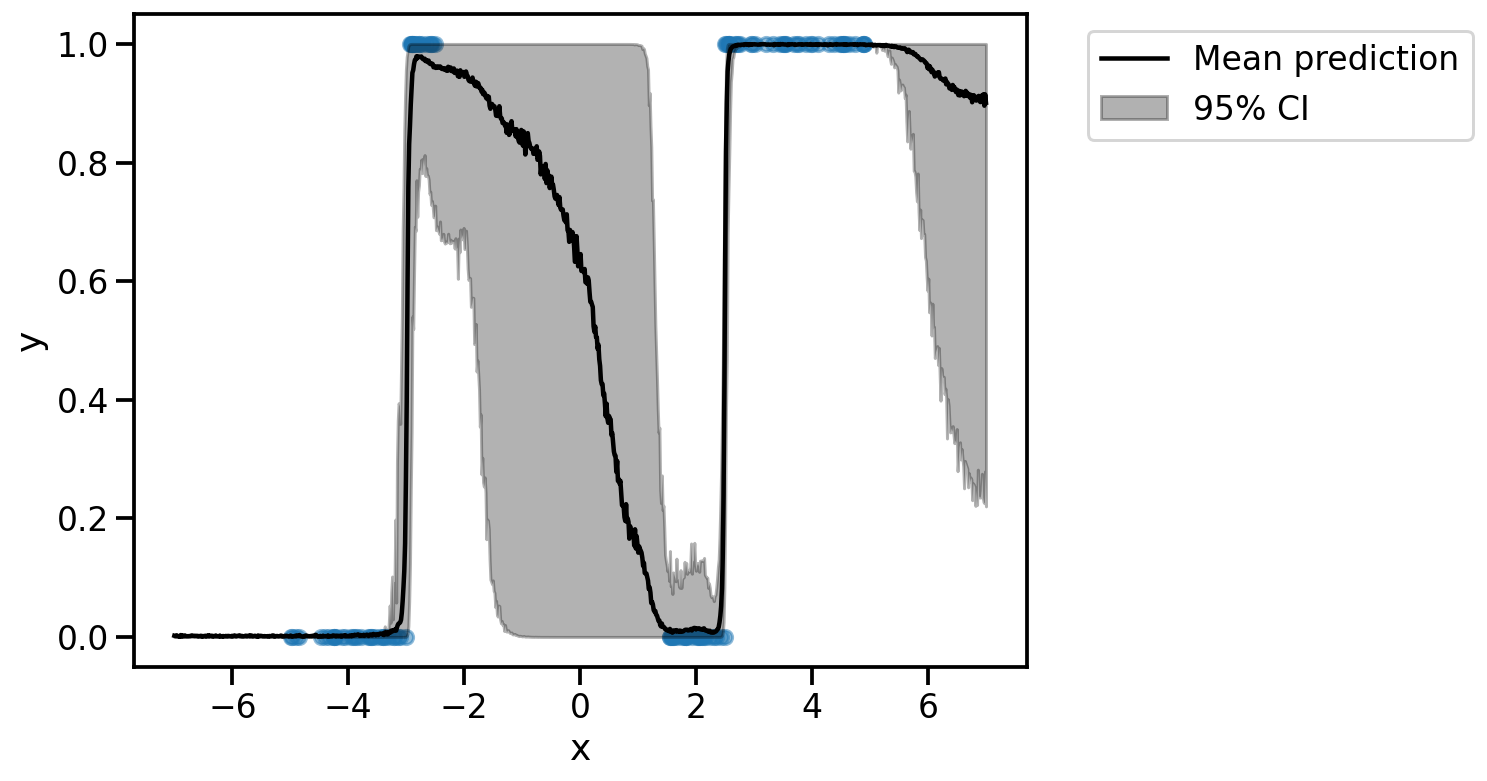

In [179]:
plt.figure(figsize=(8, 6))
plt.scatter(x.cpu(), y.cpu(), s=50, alpha=0.5)
plt.plot(x_test.cpu(), torch.mean(y_test_orig, axis=1).cpu(), color="black", label="Mean prediction")
plt.fill_between(x_test.cpu(), np.percentile(y_test_orig.cpu(), 2.5, axis=1), np.percentile(y_test_orig.cpu(), 97.5, axis=1), alpha=0.3, color="black", label="95% CI")
plt.xlabel("x")
plt.ylabel("y")
# Legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [180]:
y_test_orig

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.0430e-26, 0.0000e+00,
         0.0000e+00],
        ...,
        [5.0677e-01, 1.0000e+00, 2.8454e-01,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 6.4444e-01, 1.0000e+00,
         1.0000e+00],
        [9.9873e-01, 1.4383e-01, 3.9857e-01,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00]])

In [181]:
# Convert y_test to (n_samples, n_mc_samples, n_classes)
y_test = torch.stack([1 - y_test_orig, y_test_orig], axis=2)

y_test.shape

torch.Size([1000, 2000, 2])

In [182]:
# Compute the predictive entropy for a single example
predictive_entropy(y_test[0])

tensor(0.0214)

In [183]:
# Find MI for a single example
mutual_information(y_test[0])

tensor(0.0182)

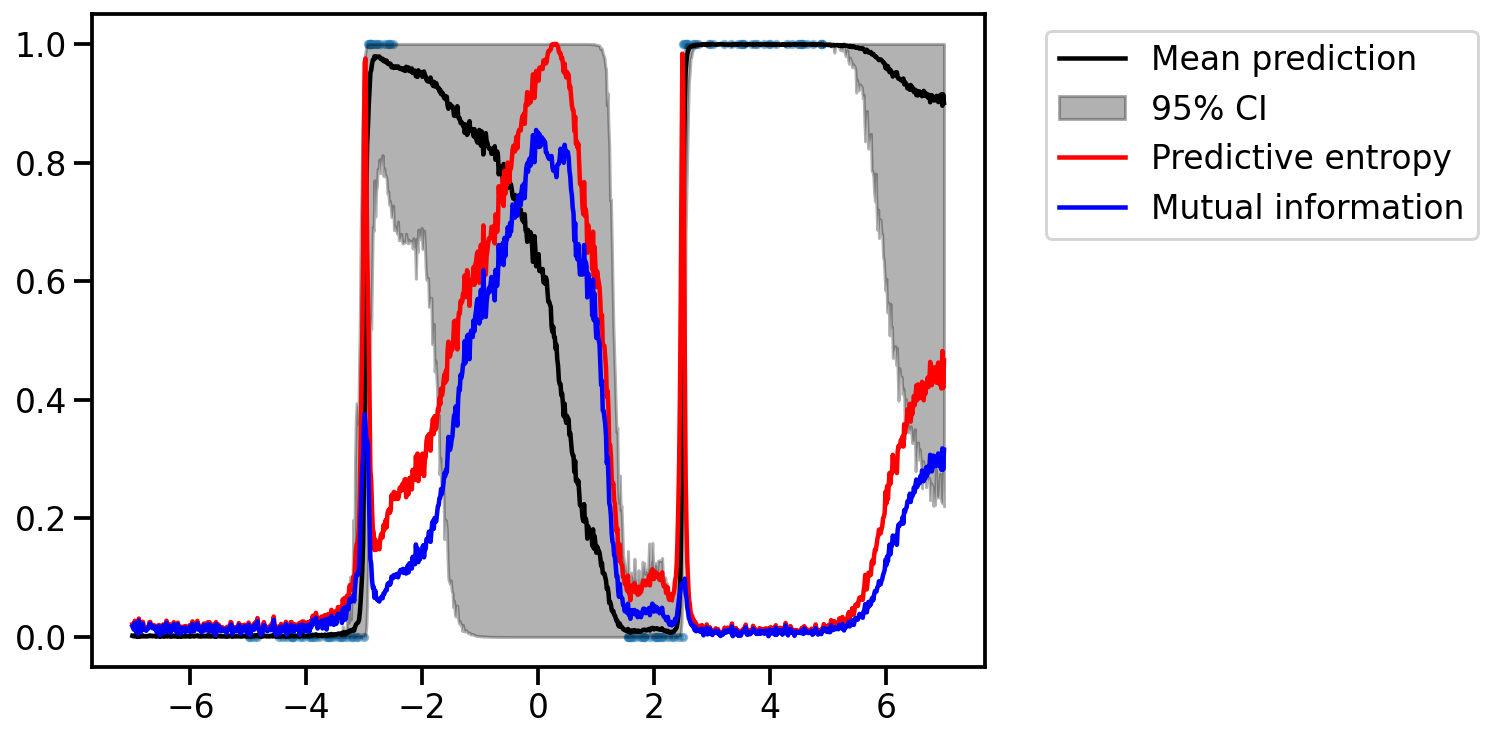

In [184]:
plt.figure(figsize=(8, 6))
plt.scatter(x.cpu(), y.cpu(), s=10, alpha=0.5)
plt.plot(x_test.cpu(), torch.mean(y_test_orig, axis=1).cpu(), color="black", label="Mean prediction")
plt.fill_between(x_test.cpu(), np.percentile(y_test_orig.cpu(), 2.5, axis=1), np.percentile(y_test_orig.cpu(), 97.5, axis=1), alpha=0.3, color="black", label="95% CI")
# Use vmap from torch to compute the predictive entropy for all examples
pred_entropy_vals = torch.func.vmap(predictive_entropy)(y_test)
plt.plot(x_test.cpu(), pred_entropy_vals, color="red", label="Predictive entropy")

# Use vmap from torch to compute the mutual information for all examples
mi_vals = torch.func.vmap(mutual_information)(y_test)
plt.plot(x_test.cpu(), mi_vals, color="blue", label="Mutual information")

# Legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')